In [ ]:
#!pip install torch torchvision torchaudio
#!pip install einops
#!pip install datasets
#!pip install transformers
#!pip install tqdm


In [12]:
import torch
from torchvision import transforms
from transformers import AutoFeatureExtractor
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image  # Importowanie PIL do obsługi obrazów
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder


Środowisko wykonawcze

In [6]:
# Wybór urządzenia GPU (CUDA), jeśli dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

Używane urządzenie: cuda


Pobranie X % zbioru treningowego ze zbioru Artificio/WikiArt_Full

In [3]:
#Pobranie zbioru danych z formatowaniem na torch
train_size = 1
ds = load_dataset('Artificio/WikiArt_Full', split= f'train[:{train_size}%]').with_format("torch")

#Wyświetlenie dostępnych kolumn
print("Dostępne kolumny:", ds.column_names)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dostępne kolumny: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats']


Ustawienie kolumny etykiet

In [4]:
#Ustalanie nazwy kolumny dla klas (style / genre / artist)
label_column = 'genre'

#Ustalanie liczby klas
num_classes = len(set(ds[label_column]))


Przygotowanie danych, resize i mapowanie

In [7]:
# Wstępne przygotowanie danych
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")

# Transformacje do formatu 224x224 i normalizacja z wykorzystaniem torchvision
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ToTensor(),
])

# Funkcja przekształcająca dane i przenosząca je na GPU
def preprocess(batch):
    images = [
        transform(img.to(device)) for img in batch["image"]  # Przekształcenie i przeniesienie na GPU
    ]
    pixel_values = torch.stack(
        [feature_extractor(image, return_tensors="pt").pixel_values.squeeze().to(device) for image in images]
    )
    return {"pixel_values": pixel_values}

# Przetwarzanie danych z przeniesieniem na CUDA
ds = ds.map(preprocess, batched=True)

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Zamiana etykiet na numeryczne, zamiana wymiarów

In [8]:
#Konwersja etykiet z tekstowych na numeryczne
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(ds[label_column])

#Przygotowanie obrazów do trenowania
train_images = torch.stack([x["pixel_values"] for x in ds]).numpy()

#Zamiana wymiarów obrazów z formatu PyTorch na TensorFlow (channels last)
#Zamienia (batch, channels, height, width) na (batch, height, width, channels)
train_images = train_images.transpose(0, 2, 3, 1)

In [10]:
#Budowanie modelu ResNet-50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Dodanie warstw do klasyfikacji z odpowiednią liczbą klas
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Trenowanie modelu
model.fit(train_images, train_labels, epochs=10, batch_size=32)

#Ekstrakcja cech z przedostatniej warstwy
feature_extractor_model = Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_extractor_model.predict(train_images)



Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.1419 - loss: 22.4340
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.4976 - loss: 2.0129
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7555 - loss: 0.8593
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8944 - loss: 0.4039
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9431 - loss: 0.2356
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9531 - loss: 0.1882
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9785 - loss: 0.1326
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9912 - loss: 0.0608
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9833 - loss: 0.0576
Epoch 10/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9962 - loss: 0.0323
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


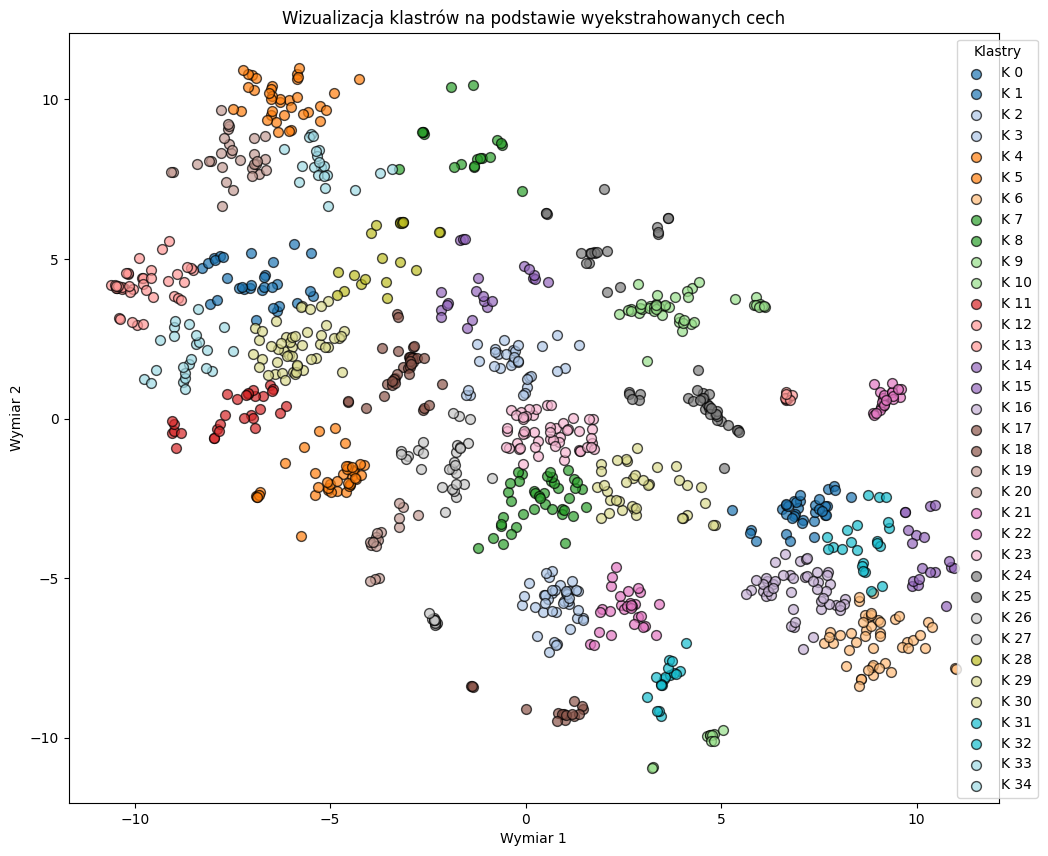

In [14]:
#Redukcja wymiarów z PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

#Redukcja wymiarów z TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

#Klasteryzacja przy użyciu KMeans
n_clusters = num_classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(tsne_result)

#Wizualizacja klastrów
plt.figure(figsize=(12, 10))

#Wygenerowanie palety kolorów
colors = cm.tab20(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    plt.scatter(
        tsne_result[clusters == i, 0],
        tsne_result[clusters == i, 1],
        color=colors[i],
        label=f'K {i}',
        alpha=0.7,
        edgecolor='k',
        s=50
    )

#Dodanie etykiet
plt.legend(loc="best", bbox_to_anchor=(1.05, 1), title="Klastry")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.title("Wizualizacja klastrów na podstawie wyekstrahowanych cech")
plt.show()